# The harmonic function method and the mass of some Schwarzschild half-spaces - Computations and Graphs

In this Jupyter Notebook, we will do two main things for our examples from Section 8:
- Compute the lower bound given by Theorem 3.9
- Plot the level sets of the harmonic coordinates

### Setting up the Python environment

In [1]:
# This file is present both as .ipynb as well as .py. For the latter, the `# %%` comment denote borders between cells so the Python file can be treated like an Jupyter notebook as well. The function below checks if the Python file is running inside a Jupyter Notebook
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__ # type: ignore[reportUndefinedVariable]
    if shell in ('ZMQInteractiveShell','XPythonShell'):
        return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
        return False  # Terminal running IPython
    else:
        return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

In [2]:
if is_notebook():
  get_ipython().run_line_magic("pip", "install gravipy matplotlib scikit-image torchquad") # this helps if this Notebook is executed from within e.g. jupyter-cloud.gwdg.de  # type: ignore[reportUndefinedVariable]

Error: nu::parser::parse_mismatch

  × Parse mismatch during operation.
   ╭─[source:1:1]
 1 │ '/mnt/data/OneDrive/Education/Studium/Bachelor-Arbeit/Positive Mass Theorem/Thesis Writing/.nix-venv/bin/python' -m pip install gravipy matplotlib scikit-image torchquad
   ·                                                                                                                  ─┬
   ·                                                                                                                   ╰── expected operator
   ╰────

Note: you may need to restart the kernel to use updated packages.


In [3]:
from gravipy.tensorial import * # import GraviPy package
import sympy
import numpy as np
import scipy
import matplotlib.pyplot as plt

# for plotting of implicit surfaces (i.e. the level sets)
from mpl_toolkits.mplot3d import axes3d
from skimage import measure

from sympy.utilities.lambdify import lambdastr

In [4]:
if is_notebook():
  from IPython.display import display, Markdown
else:
  from rich.markdown import Markdown
  from rich.console import Console
  console = Console()
  display = console.print


### Setting up the manifold, metric, etc.

In [5]:
dim = 5

non_bounded_coords_string = " ".join(f"x_{i}" for i in range(2,dim+1))
non_bounded_coords = list(symbols(non_bounded_coords_string, real=True))
x1 = symbols("x_1", nonnegative=True)
m = symbols("m",positive=True)
r_critical = symbols(r"r_0",positive=True) 
# r_critical = (m/2)**(1/(dim-2))

 
coords=[x1]+non_bounded_coords
pos = Coordinates(r'\chi',coords)
R=sympy.sqrt(sum(xi**2 for xi in coords))
omega=(1+(r_critical/R)**(dim-2))
exponent=sympy.Number(4)/(dim-2)
# metric = sympy.MatrixSymbol("g",3,3)
metric = omega**exponent*sympy.eye(dim)
g = MetricTensor('g', pos, metric)
Ga = Christoffel(r'\Gamma', g)

In [6]:
# useful for all kinds of integrals
volume_element = sympy.sqrt(sympy.Determinant(metric)).simplify()
hypersurface_volume_element = sympy.sqrt(sympy.Determinant(metric[1:,1:])).simplify()

In [7]:
# metric of hypersurface
gamma_metric = omega**exponent*sympy.diag(*([0]+[1]*(dim-1)))
gamma = MetricTensor(r'\gamma', pos, gamma_metric)
Ga_gamma = Christoffel(r'\Gamma_{\gamma}',gamma)

Some utility functions:

In [8]:
def laplacian(scalar):
  return sum([g(-i,-j)*scalar.covariantD(i,j) for i in range(1,dim+1) for j in range(1,dim+1)])

In [9]:
def gradient(symbol):
  V = Tensor(r"\Nabla "+str(symbol),1,g)
  def compute_V(idxs):
    component=sympy.diff(symbol,coords[idxs[0]-1])
    V.components.update({idxs:component})
    return component
  V._compute_contravariant_component=compute_V
  return V

### Setting up the harmonic coordinates

Define all the harmonic coordinates for $M_{m,+}$:

In [10]:
u1,*non_bounded_u = [Tensor(f"u_{i}",0,g) for i in range(1,dim+1)]
harmonic_coords = [u1]+non_bounded_u

def make_u_method(x,u):
  def u_method(idxs):
    component = x*(1+(r_critical/R)**dim)/omega
    u.components.update({idxs: component})
    return component
  return u_method

for x, u in zip(coords,harmonic_coords):
  u._compute_covariant_component = make_u_method(x,u)

And define $u_1$ for the modified Schwarzschild space $M_{m,\geq a}$ for $a>0$:

In [11]:
a = symbols("a")
u1_modified = Tensor("u_1",0,g)

def u1_modified_method(idxs):
    component = (x1+a*(r_critical/R)**(dim-2))/omega
    u1_modified.components.update({idxs: component})
    return component
u1_modified._compute_covariant_component = u1_modified_method

## Testing our Setup

### What's the mass of our space?

We use the spherical symmetry of the solution to avoid the integral, but we do evaluate the integrand in one radial direction (namely along the $x_1$-axis)

In [12]:
normal_vector_to_sphere = Tensor(r"n_{S_r}",1,g)
def n_S_r_compute_covariant_component(idxs):
  component = sympy.sqrt(g(idxs[0],idxs[0]))*coords[idxs[0]-1]/R
  normal_vector_to_sphere.components.update({idxs:component})
  return component
normal_vector_to_sphere._compute_covariant_component=n_S_r_compute_covariant_component

In [13]:
normal_vector_to_sphere(-1)

x_1*sqrt(x_1**2 + x_2**2 + x_3**2 + x_4**2 + x_5**2)/(r_0**3 + (x_1**2 + x_2**2 + x_3**2 + x_4**2 + x_5**2)**(3/2))**(2/3)

In [14]:
mass_integrand = sum((g.partialD(i,j,i)-g.partialD(i,i,j))*normal_vector_to_sphere(-j) for i,j in list(variations(range(1,dim+1),2,True)))
ray_substition = list([coord,0] for coord in non_bounded_coords)
ray_mass_integrand = mass_integrand.subs(ray_substition).simplify()

In [15]:
ray_mass_integrand

16*r_0**3/(x_1**3*(r_0**3 + x_1**3)**(1/3))

Here and in the following we will need the area of an $(n-1)$-sphere

In [16]:
sphere_volume = 2*sympy.pi ** (sympy.Number(dim) / 2) / sympy.gamma(sympy.Number(dim) / 2)
normalization = 1 / (sphere_volume * 2 * (dim - 1))
numerical_normalization = float(normalization)

In [17]:
normalization

3/(64*pi**2)

In [18]:
# volume element not strictly needed since we could also use euclidean background metric
unnormalized_mass_integral = (ray_mass_integrand*hypersurface_volume_element*(sphere_volume/2*R**(dim-1)).subs(ray_substition)).simplify()
unnormalized_mass = sympy.Limit(unnormalized_mass_integral,x1,sympy.oo).simplify()
mass = normalization*unnormalized_mass

The following should return $m/2=\tilde{r}^{n-2}$, where $n$ is the dimension.

In [19]:
display(Markdown(f"The mass is ${sympy.latex(mass)}$"))
assert(mass==(r_critical**(dim-2)).simplify())

The mass is $r_{0}^{3}$

### Is the mean curvature correct?

We compute the mean curvature of the noncompact boundary (observe that the result agrees with our computation in Section 8)

In [20]:
normal_vector_to_noncompact_boundary = Tensor(r"\nu",1,g) 
def nu_compute_covariant_component(idxs):   
  if idxs[0]==1:     
    component = -sympy.sqrt(g(1,1))   
  else:
     component = sympy.Number(0)   
  normal_vector_to_noncompact_boundary.components.update({idxs:component})  
  return component 
normal_vector_to_noncompact_boundary._compute_covariant_component=nu_compute_covariant_component

In [21]:
H=sum(g(-i,-j)*normal_vector_to_noncompact_boundary.covariantD(i,j) for i,j in variations(range(1,dim+1),2,True)).simplify()
display(Markdown(f"Mean curvature $H$ of non-compact boundary is ${sympy.latex(H)}$, which is the same as $\\frac{{2 (n-1)\\tilde{{r}}^{{n-2}}}}{{r^n\\cdot \omega^{{2/(n-2)+1}}}}x_1={sympy.latex((2*(dim-1)*r_critical**(dim-2)*x1/(R**dim*omega**(sympy.Number(2)/(dim-2)+1))).simplify())}$."))
assert((H-2*(dim-1)*r_critical**(dim-2)*x1/(R**dim*omega**(sympy.Number(2)/(dim-2)+1))).simplify()==0)

Mean curvature $H$ of non-compact boundary is $\frac{8 r_{0}^{3} x_{1}}{\left(r_{0}^{3} + \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{3}{2}}\right)^{\frac{5}{3}}}$, which is the same as $\frac{2 (n-1)\tilde{r}^{n-2}}{r^n\cdot \omega^{2/(n-2)+1}}x_1=\frac{8 r_{0}^{3} x_{1}}{\left(r_{0}^{3} + \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{3}{2}}\right)^{\frac{5}{3}}}$.


The above is greater than $0$ in particular if $x_1>0$.

### Are our functions truly harmonic?

In [22]:
u1()

x_1*(r_0**5/(x_1**2 + x_2**2 + x_3**2 + x_4**2 + x_5**2)**(5/2) + 1)/(r_0**3/(x_1**2 + x_2**2 + x_3**2 + x_4**2 + x_5**2)**(3/2) + 1)

In [23]:
print("Harmonicity check:")
for i,u in enumerate(harmonic_coords):
  current_laplacian = laplacian(u).simplify()
  display(Markdown(f"$\Delta u_{i+1}={sympy.latex(current_laplacian)}$"))
  # assert(current_laplacian==0)

Harmonicity check:


$\Delta u_1=0$

$\Delta u_2=0$

$\Delta u_3=0$

$\Delta u_4=0$

$\Delta u_5=0$

In [24]:
laplacian_modified = laplacian(u1_modified).simplify()
display(Markdown(f"For $M_{{m,\geq a}}$: $\Delta u_1={laplacian_modified}$"))
assert(laplacian_modified == 0)

For $M_{m,\geq a}$: $\Delta u_1=0$

### Are the boundary conditions truly fulfilled?

For $a=0$ we should in particular have $\partial_r u_i\vert_{r=\tilde{r}}=0$:

In [25]:
for (i,u) in enumerate(harmonic_coords):
  radial_derivative = sum(u.covariantD(i+1)*coords[i] for i in range(dim))
  substitution = [x1,sympy.sqrt(r_critical**2-sum(coord**2 for coord in non_bounded_coords))]
  radial_derivative_substituted = radial_derivative.subs([substitution]).simplify()
  display(Markdown(f"$\partial_r u_{i+1}\\vert_{{r=\\tilde{{r}}}}={sympy.latex(radial_derivative_substituted)}$"))
  assert(radial_derivative_substituted==0)

$\partial_r u_1\vert_{r=\tilde{r}}=0$

$\partial_r u_2\vert_{r=\tilde{r}}=0$

$\partial_r u_3\vert_{r=\tilde{r}}=0$

$\partial_r u_4\vert_{r=\tilde{r}}=0$

$\partial_r u_5\vert_{r=\tilde{r}}=0$

For $a>0$, we should have $\tilde{u}_1\vert_{x_1=a}=a$:

In [26]:
u1_modified_at_x1_equal_a=u1_modified().subs([[x1,a]]).simplify()
display(Markdown(f"$\\tilde{{u}}_1\\vert_{{x_1=a}}={u1_modified_at_x1_equal_a}$"))
assert(u1_modified_at_x1_equal_a==a)

$\tilde{u}_1\vert_{x_1=a}=a$

### Are there any critical points?

It is interesting to consider whether there are any critical points of $u_3$ to be able to discuss how strong the lower bound given by our technique is (see Remark 4.3).

##### For $M_{m,+}$ there is at least one (at (0,0,m/2)):

In [27]:
display(
    Markdown(
        f"On $M_{{m,+}}$, there is at least one critical point: At $(0,0,\\tilde{{r}})$ we have $\operatorname{{grad}} u_1={sympy.latex(sympy.Array([u1.covariantD(i) for i in range(1,4)]).subs(([(x1,r_critical)]+list(map(lambda coord: (coord,0),non_bounded_coords)))).simplify())}$"
    )
)

On $M_{m,+}$, there is at least one critical point: At $(0,0,\tilde{r})$ we have $\operatorname{grad} u_1=\left[\begin{matrix}0 & 0 & 0\end{matrix}\right]$

##### For $M_{m,\geq a}$:

In [28]:
relevant_derivative = u1_modified.covariantD(1).simplify()
only_numerator = sympy.fraction(relevant_derivative)[0].expand()
display(Markdown(f"""On $M_{{m,\geq a}} (for $a>0$), $u_1$ has no critical points! 
                 
It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1={sympy.latex(relevant_derivative)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator ${sympy.latex(only_numerator)}$.

But $x_1\geq a > 0$ and thus each of the negative terms in front are balanced out by later terms."""))

On $M_{m,\geq a} (for $a>0$), $u_1$ has no critical points! 
                 
It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1=\frac{3 r_{0}^{3} x_{1} \left(a r_{0}^{3} + x_{1} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{3}{2}}\right) - \left(r_{0}^{3} + \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{3}{2}}\right) \left(3 a r_{0}^{3} x_{1} - \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{5}{2}}\right)}{\left(r_{0}^{3} + \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)^{\frac{3}{2}}\right)^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}\right)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator $- 3 a r_{0}^{3} x_{1}^{3} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} - 3 a r_{0}^{3} x_{1} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} - 3 a r_{0}^{3} x_{1} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} - 3 a r_{0}^{3} x_{1} x_{4}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} - 3 a r_{0}^{3} x_{1} x_{5}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 4 r_{0}^{3} x_{1}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 5 r_{0}^{3} x_{1}^{2} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 5 r_{0}^{3} x_{1}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 5 r_{0}^{3} x_{1}^{2} x_{4}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 5 r_{0}^{3} x_{1}^{2} x_{5}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + r_{0}^{3} x_{2}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{2}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{2}^{2} x_{4}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{2}^{2} x_{5}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + r_{0}^{3} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{3}^{2} x_{4}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{3}^{2} x_{5}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + r_{0}^{3} x_{4}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + 2 r_{0}^{3} x_{4}^{2} x_{5}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + r_{0}^{3} x_{5}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2} + x_{5}^{2}} + x_{1}^{8} + 4 x_{1}^{6} x_{2}^{2} + 4 x_{1}^{6} x_{3}^{2} + 4 x_{1}^{6} x_{4}^{2} + 4 x_{1}^{6} x_{5}^{2} + 6 x_{1}^{4} x_{2}^{4} + 12 x_{1}^{4} x_{2}^{2} x_{3}^{2} + 12 x_{1}^{4} x_{2}^{2} x_{4}^{2} + 12 x_{1}^{4} x_{2}^{2} x_{5}^{2} + 6 x_{1}^{4} x_{3}^{4} + 12 x_{1}^{4} x_{3}^{2} x_{4}^{2} + 12 x_{1}^{4} x_{3}^{2} x_{5}^{2} + 6 x_{1}^{4} x_{4}^{4} + 12 x_{1}^{4} x_{4}^{2} x_{5}^{2} + 6 x_{1}^{4} x_{5}^{4} + 4 x_{1}^{2} x_{2}^{6} + 12 x_{1}^{2} x_{2}^{4} x_{3}^{2} + 12 x_{1}^{2} x_{2}^{4} x_{4}^{2} + 12 x_{1}^{2} x_{2}^{4} x_{5}^{2} + 12 x_{1}^{2} x_{2}^{2} x_{3}^{4} + 24 x_{1}^{2} x_{2}^{2} x_{3}^{2} x_{4}^{2} + 24 x_{1}^{2} x_{2}^{2} x_{3}^{2} x_{5}^{2} + 12 x_{1}^{2} x_{2}^{2} x_{4}^{4} + 24 x_{1}^{2} x_{2}^{2} x_{4}^{2} x_{5}^{2} + 12 x_{1}^{2} x_{2}^{2} x_{5}^{4} + 4 x_{1}^{2} x_{3}^{6} + 12 x_{1}^{2} x_{3}^{4} x_{4}^{2} + 12 x_{1}^{2} x_{3}^{4} x_{5}^{2} + 12 x_{1}^{2} x_{3}^{2} x_{4}^{4} + 24 x_{1}^{2} x_{3}^{2} x_{4}^{2} x_{5}^{2} + 12 x_{1}^{2} x_{3}^{2} x_{5}^{4} + 4 x_{1}^{2} x_{4}^{6} + 12 x_{1}^{2} x_{4}^{4} x_{5}^{2} + 12 x_{1}^{2} x_{4}^{2} x_{5}^{4} + 4 x_{1}^{2} x_{5}^{6} + x_{2}^{8} + 4 x_{2}^{6} x_{3}^{2} + 4 x_{2}^{6} x_{4}^{2} + 4 x_{2}^{6} x_{5}^{2} + 6 x_{2}^{4} x_{3}^{4} + 12 x_{2}^{4} x_{3}^{2} x_{4}^{2} + 12 x_{2}^{4} x_{3}^{2} x_{5}^{2} + 6 x_{2}^{4} x_{4}^{4} + 12 x_{2}^{4} x_{4}^{2} x_{5}^{2} + 6 x_{2}^{4} x_{5}^{4} + 4 x_{2}^{2} x_{3}^{6} + 12 x_{2}^{2} x_{3}^{4} x_{4}^{2} + 12 x_{2}^{2} x_{3}^{4} x_{5}^{2} + 12 x_{2}^{2} x_{3}^{2} x_{4}^{4} + 24 x_{2}^{2} x_{3}^{2} x_{4}^{2} x_{5}^{2} + 12 x_{2}^{2} x_{3}^{2} x_{5}^{4} + 4 x_{2}^{2} x_{4}^{6} + 12 x_{2}^{2} x_{4}^{4} x_{5}^{2} + 12 x_{2}^{2} x_{4}^{2} x_{5}^{4} + 4 x_{2}^{2} x_{5}^{6} + x_{3}^{8} + 4 x_{3}^{6} x_{4}^{2} + 4 x_{3}^{6} x_{5}^{2} + 6 x_{3}^{4} x_{4}^{4} + 12 x_{3}^{4} x_{4}^{2} x_{5}^{2} + 6 x_{3}^{4} x_{5}^{4} + 4 x_{3}^{2} x_{4}^{6} + 12 x_{3}^{2} x_{4}^{4} x_{5}^{2} + 12 x_{3}^{2} x_{4}^{2} x_{5}^{4} + 4 x_{3}^{2} x_{5}^{6} + x_{4}^{8} + 4 x_{4}^{6} x_{5}^{2} + 6 x_{4}^{4} x_{5}^{4} + 4 x_{4}^{2} x_{5}^{6} + x_{5}^{8}$.

But $x_1\geq a > 0$ and thus each of the negative terms in front are balanced out by later terms.

## Computation of the lower bound

Let's try to compute the lower bound for the mass. We avoid simplifying anything (I once tried to let `sympy` simplify `abs_hessian_u1`, and it did complete, but only after 10 hours!). Even with manual help factoring out $\omega$ terms and the like, the computation times are still often in the minutes. The numerical integration later on is fast enough to deal with unoptimized expressions.

In [29]:
abs_nabla_u1=sympy.sqrt(sum(g(-i,-j)*u1.covariantD(i)*u1.covariantD(j) for i in range(1,dim+1) for j in range(1,dim+1)))

In [30]:
abs_nabla_u1_modified=sympy.sqrt(sum(g(-i,-j)*u1_modified.covariantD(i)*u1_modified.covariantD(j) for i in range(1,dim+1) for j in range(1,dim+1)))

In [31]:
abs_hessian_u1=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u1.covariantD(i,j)*u1.covariantD(k,l) for i,j,k,l in list(variations(range(1, dim+1), 4, True))))

In [32]:
abs_hessian_u1_modified=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u1_modified.covariantD(i,j)*u1_modified.covariantD(k,l) for i,j,k,l in variations(range(1, dim+1), 4, True)))

We can now express the integrands. Note that we need to include the volume element. Also we have $R=0$, so the second term in the integrand disappears

In [33]:
lower_bound_integrand_over_M=(abs_hessian_u1**2/abs_nabla_u1)*volume_element
lower_bound_modified_integrand_over_M=((abs_hessian_u1_modified**2/abs_nabla_u1_modified)*volume_element)

We can now also write down the expression for integral term on the boundary (we need to use the volume element of $\Sigma$ here). Note that the integrand over the boundary vanishes for $M_{m,+}$.

In [34]:
lower_bound_integrand_over_boundary = 2*(H.subs(x1,0).simplify()*abs_nabla_u1)*hypersurface_volume_element
print(f"{lower_bound_integrand_over_boundary=}")
assert(lower_bound_integrand_over_boundary==0)

lower_bound_modified_integrand_over_boundary = 2*(H.subs(x1,a).simplify()*abs_nabla_u1_modified)*hypersurface_volume_element

lower_bound_integrand_over_boundary=0


We use `sympy.lambdify` to get numerical expressions for our integrands. 

In [37]:
import tensorflow as tf

# numerical implementation (reverse args as we want x1 integration to be outermost)
num_lower_bound_integrand_over_M = sympy.lambdify(list(reversed(coords))+[r_critical],lower_bound_integrand_over_M,modules=tf)
num_lower_bound_integrand_over_boundary = sympy.lambdify(list(reversed(coords))+[r_critical],lower_bound_integrand_over_boundary,modules=tf)

# and we shift this one integrand so that the integral will be centered at 0
num_lower_bound_modified_integrand_over_M = sympy.lambdify(
    list(reversed(coords)) + [r_critical,a], lower_bound_modified_integrand_over_M.subs(x1,x1+a)
,modules=tf)
num_lower_bound_modified_integrand_over_boundary = sympy.lambdify(
    list(reversed(coords)) + [r_critical, a], lower_bound_modified_integrand_over_boundary,modules=tf
)

2024-02-27 23:11:19.349238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 23:11:19.350009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 23:11:19.456734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 23:11:19.688367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 23:11:28.657446: W tensorflow/compiler/tf2

We can now do the numerical integration. Due to symmetry we are able to only integrate over one quadrant ($x_2\geq 0, \dotsc, x_n\geq 0$ in addition to the usual $x_1\geq 0$) and multiply by $2^{n-1}$ afterwards.

In [38]:
number_quadrants = 2**(dim-1)
r_critical_value = 0.5

In [74]:
from vegasflow import VegasFlowPlus
from vegasflow.utils import generate_condition_function
from vegasflow.configflow import DTYPE
or_cond = generate_condition_function(2,condition="or")
from functools import cache


def make_integrand(expr, r_critical_value, a_value, extra_args):
  
  # Convert extra_args to a TensorFlow tensor
  extra_args_tensor = tf.convert_to_tensor(extra_args, dtype=DTYPE)
    
  def integrand(xarr):
    outside_horizon = tf.norm(xarr,axis=1)>r_critical_value
    a_nonzero_cond = xarr[:,0]*0+a_value>0
    mask,idx = or_cond(outside_horizon,a_nonzero_cond)
    masked_xarr = tf.boolean_mask(xarr, mask, axis=0)

    # Reshape extra_args to have shape (1, extra_args_size)
    extra_args_expanded = tf.expand_dims(extra_args_tensor, axis=0)
    
    # Broadcast extra_args along the batch dimension to match the batch size of xarr
    extra_args_broadcasted = tf.tile(extra_args_expanded, [tf.shape(masked_xarr)[0], 1])
    
    # Concatenate xarr with extra_args_broadcasted along axis 1
    full_expr_args = tf.concat([masked_xarr, extra_args_broadcasted], axis=1)
  
    result = expr(*tf.unstack(full_expr_args,axis=1))
    # Return a sparse tensor so that only the actual results have a value
    return tf.scatter_nd(idx, result,shape=tf.shape(outside_horizon))
  return integrand


def make_vegas_instance(expr,integration_dim, r_critical_value, a_value, extra_args,n_calls = int(1e6),box_size=1e5):
  vegas_instance = VegasFlowPlus(integration_dim, n_calls, xmin=[0]*integration_dim,xmax=[box_size]*integration_dim)
  integrand = make_integrand(expr, r_critical_value, a_value, extra_args)
  vegas_instance.compile(integrand)
  return vegas_instance


In [75]:
class LowerBoundCalculator:
    def __init__(self,r_critical_value=r_critical_value,a_value=0,box_size=1e4,n_calls=int(1e6)):
        self.a_value=a_value
        if a_value!=0:
            manifold_expr = num_lower_bound_modified_integrand_over_M
            boundary_expr = num_lower_bound_modified_integrand_over_boundary
            main_extra_args = [r_critical_value, a_value]
        else:
            manifold_expr = num_lower_bound_integrand_over_M
            boundary_expr = num_lower_bound_integrand_over_boundary
            main_extra_args = [r_critical_value]
        self.manifold_integrator = make_vegas_instance(expr=manifold_expr,integration_dim=dim,r_critical_value=r_critical_value, a_value=a_value,extra_args=main_extra_args,n_calls=n_calls,box_size=box_size)
        if a_value!=0:
            self.boundary_integrator = make_vegas_instance(expr=boundary_expr,integration_dim=dim-1,r_critical_value=r_critical_value, a_value=a_value,extra_args=[a_value]+main_extra_args,n_calls=n_calls,box_size=box_size)
        return

    def run_integration(self,n_iter=5):
        result_on_M = self.manifold_integrator.run_integration(n_iter)
        if self.a_value!=0:
            result_on_boundary = self.boundary_integrator.run_integration(n_iter)
        else:
            result_on_boundary = [0,0] # we know that the boundary integrand is zero for the a=0 case 
        lower_bound_M = numerical_normalization*number_quadrants * result_on_M[0]
        lower_bound_boundary = numerical_normalization*number_quadrants * result_on_boundary[0]
        error_M = numerical_normalization*number_quadrants * result_on_M[1]
        error_boundary = numerical_normalization*number_quadrants * result_on_boundary[1]
        # number_evaluations_modified = result_on_M[2]['neval'] + result_on_boundary[2]['neval'] # most of these will come from the boundary integral where we set the `limit` parameter higher
        total_lower_bound = lower_bound_M + lower_bound_boundary
        total_error = error_M + error_boundary
        return [
            total_lower_bound,
            total_error,
            lower_bound_M,
            error_M,
            lower_bound_boundary,
            error_boundary,
        ]

We use the smart VEGAS algorithm (optionally even on GPU!) and this solves our speed problems. Though we choose a small box size to help it focus on the difficult part of the integral

In [76]:
a_equal_0_case = LowerBoundCalculator(a_value=0,box_size=1e5)

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)


In [ ]:
_ = a_equal_0_case.run_integration(n_iter=10) # train the integrator

In [96]:
result=a_equal_0_case.run_integration(n_iter=1) # actually get the result

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 0.5830 +/- 0.0034(took 5.26006 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.583002 +/- 0.00342583


In [97]:
schwarzschild_half_space_mass_lower_bound = result[0]
m_value=r_critical_value**(dim-2)*2
schwarzschild_half_space_mass_lower_bound_sigma = result[1]
display(Markdown(f"## Lower bound for mass (expected $m/2={m_value}/2={m_value/2}$) of $M_{{{m_value},+}}$ with dimension $n={dim}$ calculated as ${schwarzschild_half_space_mass_lower_bound:.5f}$ with Monte Carlo error ${schwarzschild_half_space_mass_lower_bound_sigma:.5f}$."))

## Lower bound for mass (expected $m/2=0.25/2=0.125$) of $M_{0.25,+}$ with dimension $n=5$ calculated as $0.04430$ with Monte Carlo error $0.00026$.

We can now do the same process for $M_{m,\geq a}$ for $a>0$:

In [86]:
a_value = 2


In [87]:
a_equal_2_case = LowerBoundCalculator(a_value=2,box_size=1e5)

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)


[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)


In [ ]:
_ = a_equal_2_case.run_integration(n_iter=10) # train the integrator

In [94]:
result_modified=a_equal_2_case.run_integration(n_iter=1) # actually get the result

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.922e-03 +/- 3.568e-06(took 5.32303 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.00292156 +/- 3.56756e-06


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6451 +/- 0.0023(took 4.29163 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.64506 +/- 0.00227153


In [95]:
modified_schwarzschild_half_space_mass_lower_bound = result_modified[0]
error_estimate_modified = result_modified[1]
display(Markdown(f"## Lower bound for mass $m/2={m_value/2}$ of $M_{{m,\geq {a_value}}}$ calculated as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with Monte Carlo error ${error_estimate_modified:.5f}$."))

## Lower bound for mass $m/2=0.125$ of $M_{m,\geq 2}$ calculated as $0.12523$ with Monte Carlo error $0.00017$.

We can repeat this calculation for different values of $a$ and plot the results:

Computing the values for the plot might take a while

In [98]:
a_values = np.array([1,2,5,10,100])
r_critical_value = 0.5
lower_bound_calculators = [(LowerBoundCalculator(a_value=a_value,r_critical_value=r_critical_value,box_size=1e5) if a_value!=2 else a_equal_2_case) for a_value in a_values]

[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Events per device limit set to 1000000
[INFO] (vegasflow.monte_carlo) Checking whether the integrand outputs the correct shape (note, this will run a very small number of events and potentially trigger a retrace)
[INFO] (vegasflow.vflowplus) Eve

In [99]:
# train integrators
for lower_bound_calculator in lower_bound_calculators:
  if lower_bound_calculator.a_value == 2:
    continue
  _ = lower_bound_calculator.run_integration(n_iter=7)

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 5.364e-12 +/- 4.084e-12(took 9.87426 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.062e-09 +/- 1.403e-09(took 5.74179 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 2.203e-08 +/- 4.315e-09(took 5.35212 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.863e-05 +/- 1.467e-05(took 5.40462 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 6.458e-03 +/- 2.280e-03(took 7.11961 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 2.313e-02 +/- 6.658e-04(took 7.23153 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 2.259e-02 +/- 2.879e-05(took 7.99112 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 5.40182e-12 +/- 4.08389e-12


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.881e-02 +/- 2.224e-02(took 5.91915 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.924e-02 +/- 1.579e-02(took 4.70474 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 0.1985 +/- 0.0367(took 4.88999 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.4716 +/- 0.0960(took 3.50698 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.6271 +/- 0.0029(took 3.69062 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.6245 +/- 0.0016(took 3.61190 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.6265 +/- 0.0033(took 3.95268 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.60772 +/- 0.0012825


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 9.652e-12 +/- 9.083e-12(took 8.07647 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.094e-09 +/- 5.428e-10(took 5.86409 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 2.358e-07 +/- 1.552e-07(took 6.36310 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 9.897e-05 +/- 5.328e-05(took 5.16644 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.910e-04 +/- 5.922e-06(took 5.35654 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.879e-04 +/- 4.457e-07(took 5.09255 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.879e-04 +/- 1.651e-07(took 5.01349 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.06031e-11 +/- 9.08195e-12


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.796e-03 +/- 4.856e-04(took 4.43561 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.1038 +/- 0.0509(took 4.29391 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 0.6531 +/- 0.1081(took 3.76619 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.6362 +/- 0.0139(took 3.49258 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.6459 +/- 0.0036(took 3.42108 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.6485 +/- 0.0033(took 3.37715 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.6449 +/- 0.0021(took 3.67862 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.147539 +/- 0.000463692


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.431e-13 +/- 9.231e-14(took 8.30254 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 8.706e-11 +/- 7.145e-11(took 5.11349 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.847e-07 +/- 1.752e-07(took 5.38319 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.813e-06 +/- 1.038e-06(took 5.98674 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 2.063e-05 +/- 1.072e-06(took 4.78263 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 2.353e-05 +/- 2.605e-08(took 4.76123 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 2.347e-05 +/- 2.187e-08(took 5.83056 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 2.43966e-13 +/- 9.23133e-14


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 7.398e-03 +/- 1.570e-03(took 4.25372 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 1.6844 +/- 1.5531(took 3.65853 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.0422 +/- 0.0863(took 3.94120 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.6496 +/- 0.0071(took 4.57888 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.6471 +/- 0.0032(took 4.44276 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.6446 +/- 0.0017(took 4.61179 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.6431 +/- 0.0025(took 4.66606 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.00592 +/- 0.000980384


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.291e-11 +/- 2.249e-11(took 9.33579 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 2.037e-10 +/- 8.043e-11(took 5.98872 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 6.940e-09 +/- 2.651e-09(took 5.77556 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 2.350e-08 +/- 4.149e-10(took 6.01429 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 2.355e-08 +/- 4.949e-11(took 5.65760 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 2.359e-08 +/- 5.172e-11(took 5.33735 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 2.361e-08 +/- 5.679e-11(took 5.50403 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 8.03913e-09 +/- 1.75948e-11


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 0.1144 +/- 0.0421(took 4.93305 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 1: 0.9443 +/- 0.2141(took 4.69862 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 2: 1.6505 +/- 0.0054(took 3.95719 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 3: 1.6416 +/- 0.0040(took 4.73144 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 4: 1.6448 +/- 0.0014(took 3.99258 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 5: 1.6435 +/- 0.0019(took 4.12635 s)


[INFO] (vegasflow.monte_carlo) Result for iteration 6: 1.6434 +/- 0.0013(took 4.28510 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.64343 +/- 0.000824191


In [100]:
# get results
total_lower_bounds,total_errors,lower_bounds_M, errors_M, lower_bounds_boundary, errors_boundary = np.fromiter(
  (lower_bound_calculator.run_integration(n_iter=1) for lower_bound_calculator in lower_bound_calculators),
  np.dtype((float,6))).transpose()

[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.269e-02 +/- 8.862e-05(took 2.78668 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.0226898 +/- 8.86225e-05


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6256 +/- 0.0028(took 2.05042 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.62563 +/- 0.00279375


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.936e-03 +/- 8.921e-06(took 2.27283 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.00293599 +/- 8.92078e-06


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6409 +/- 0.0017(took 1.66138 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.64093 +/- 0.001748


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.874e-04 +/- 1.876e-07(took 2.50769 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 0.000187362 +/- 1.87577e-07


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6449 +/- 0.0019(took 3.06452 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.64495 +/- 0.00187873


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.352e-05 +/- 4.829e-08(took 5.06299 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 2.35164e-05 +/- 4.82928e-08


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6438 +/- 0.0016(took 2.76755 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.64382 +/- 0.00157843


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 2.346e-08 +/- 2.689e-11(took 3.63614 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 2.34635e-08 +/- 2.68943e-11


[INFO] (vegasflow.monte_carlo) Result for iteration 0: 1.6438 +/- 0.0018(took 2.76849 s)
[INFO] (vegasflow.monte_carlo)  > Final results: 1.6438 +/- 0.00176199


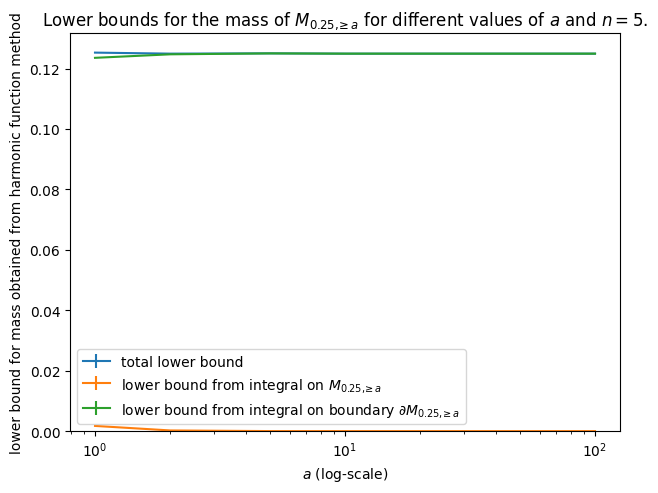

In [101]:
plt.errorbar(a_values,total_lower_bounds,yerr=total_errors,label=f"total lower bound")
plt.errorbar(a_values,lower_bounds_M,yerr=errors_M,label=f"lower bound from integral on $ M_{{{m_value},\!\!\geq a}}$")
plt.errorbar(a_values,lower_bounds_boundary,yerr=errors_boundary,label=f"lower bound from integral on boundary $\partial M_{{{m_value},\!\!\geq a}}$")
plt.xscale('log')
plt.gca().set_ylim(bottom=0)
plt.xlabel("$a$ (log-scale)")
plt.ylabel("lower bound for mass obtained from harmonic function method")
plt.legend()
plt.tight_layout()
plt.title(f"Lower bounds for the mass of $M_{{{m_value},\!\!\geq a}}$ for different values of $a$ and $n={dim}$.")
plt.savefig("../figures/lower_bounds_for_different_values_of_a",bbox_inches='tight')

## Plotting the harmonic coordinates

### Plotting Utilities

Matplotlib does not come with a method of plotting implicit surfaces. The following approach is from [answers to this Stack Overflow question](https://stackoverflow.com/questions/4680525/plotting-implicit-equations-in-3d).

```python
# https://stackoverflow.com/a/4687582
def plot_implicit_using_contours(ax,fn,level_set_value=0, bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50,samples=30):
    """ Create a plot of a 2d implicite surface fn(x,y,z)=level_set_value using contours

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
        samples (int, optional): Number of slices to take
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin, xmax, resolution)
    yl = np.linspace(ymin,ymax,resolution)
    zl = np.linspace(zmin, zmax, samples)
    A1, A2 = np.meshgrid(xl,xl)

    for z in zl: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z)-level_set_value
        cset = ax.contour(X, Y, Z+z-level_set_value, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in zl: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z)-level_set_value
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    for x in zl: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z)-level_set_value
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

def plot_implicit_using_marching_cubes(ax,fn,level_set_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
    """ Create a plot of a 2d implicit surface fn(x,y,z)=level_set_value using marching cubes

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin,xmax, resolution)
    yl = np.linspace(ymin,ymax, resolution)
    zl = np.linspace(zmin,zmax, resolution)
    X, Y, Z = np.meshgrid(xl, yl, zl)
    F=fn(X,Y,Z)


    verts, faces, normals, values = measure.marching_cubes(F, level_set_value, spacing=[np.diff(xl)[0],np.diff(yl)[0],np.diff(zl)[0]])
    # need to correct vertex coordinates as they are expressed in Voxel coordinates
    verts += (xmin,ymin,zmin)
    
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, 
                    verts[:, 2], # color
                    cmap='magma',vmin=zmin,vmax=zmax)
    
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)
    return verts, faces
```

```python
def plot_coordinate_level_sets(coordinate,level_set_values=(0),m_value=1,a_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
  fn = sympy.lambdify([x1,x2,x1],(coordinate()).subs(((m,m_value),(a,a_value))))

  n_plots = len(level_set_values)
  n_cols = min(2,n_plots)
  n_rows = (n_plots+1)//2

  fig = plt.figure(figsize=(10,n_rows*4+1))
  fig.suptitle(f"Level sets of ${sympy.latex(coordinate.symbol)}$ on $M_{{{m_value},\!\!\geq {a_value}}}$",fontsize=20,y=0,va="top")

  axes = fig.subplots(ncols=n_cols,nrows=n_rows,subplot_kw=dict(projection='3d'),squeeze=False)

  if n_plots<n_rows*2:
    fig.delaxes(axes[n_rows-1,n_cols-1]) # delete last axis if unneccessary

  for index, level_set_value in enumerate(level_set_values):
    ax = axes.flatten()[index]
    ax.set_title(f"${sympy.latex(coordinate.symbol)}={level_set_value:.2f}$",fontsize=16,pad=0)
    ax.locator_params(nbins=4)
    
    plot_implicit_using_marching_cubes(ax,fn,level_set_value,bbox=bbox,resolution=resolution)
    ax.set_aspect('equal')
  fig.tight_layout(h_pad=5)
  return fig
```

### Plots for $M_{m,+}=M_{m,\geq 0}$

```python
fig=plot_coordinate_level_sets(u1,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],bbox=[(-1.5,1.5),(-1.5,1.5),(0,1.1)])
fig.savefig("../figures/level_sets_u1_unmodified",bbox_inches='tight')
````

```python
plot_coordinate_level_sets(u2,[-0.75,-0.5,-0.25,0,0.25,0.5,0.75],bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.1)])
plt.savefig("../figures/level_sets_u2_unmodified",bbox_inches="tight")
```

### Plots for $M_{m,\!\!\geq a}$. We can symbolically check that the boundary $x_3=a$ is actually a level set. Numerically this level set is not quite correctly computed due to rounding errors. 

```python
for a_value in [0.1,0.3]:
  fig=plot_coordinate_level_sets(u1_modified,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])+a_value,a_value=a_value,bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.5)],resolution=100)
  fig.savefig(f'../figures/level_sets_u1_modified_with_a_{a_value}.png',bbox_inches='tight')
```